<a href="https://colab.research.google.com/github/MeatHub/CBIR-Animal-Autoencoder/blob/main/Animal_Image_Retrieval(CBIR)_%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.neighbors import NearestNeighbors
from torchsummary import summary

In [15]:
!pip install kagglehub barbar torchsummary

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
import kagglehub

path = kagglehub.dataset_download("theaayushbajaj/cbir-dataset")
print("Path to dataset files:", path)

DATASET_PATH = path

100%|██████████| 232M/232M [00:11<00:00, 20.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/theaayushbajaj/cbir-dataset/versions/1


In [18]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 15

In [19]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CBIRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, img_path
        except:
            # 깨진 이미지 대비 예외 처리
            return torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE), img_path

dataset = CBIRDataset(DATASET_PATH, transform=transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"데이터 준비 완료: 총 {len(dataset)}장")

데이터 준비 완료: 총 4738장


In [20]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 16x16
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256)
        )
        # Decoder
        self.decoder_input = nn.Linear(256, 128 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        latent = self.encoder(x)
        x = self.decoder_input(latent)
        x = x.view(x.size(0), 128, 16, 16)
        x = self.decoder(x)
        return x

model = ConvAutoencoder().to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
              ReLU-6          [-1, 128, 16, 16]               0
           Flatten-7                [-1, 32768]               0
            Linear-8                  [-1, 256]       8,388,864
            Linear-9                [-1, 32768]       8,421,376
  ConvTranspose2d-10           [-1, 64, 32, 32]          73,792
             ReLU-11           [-1, 64, 32, 32]               0
  ConvTranspose2d-12           [-1, 32, 64, 64]          18,464
             ReLU-13           [-1, 32, 64, 64]               0
  ConvTranspose2d-14          [-1, 3, 1

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    model.train()
    for images, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}'):
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] 평균 Loss: {train_loss / len(dataset):.4f}')

Epoch 1/15: 100%|██████████| 149/149 [00:22<00:00,  6.54it/s]


Epoch [1/15] 평균 Loss: 0.1196


Epoch 2/15: 100%|██████████| 149/149 [00:22<00:00,  6.49it/s]


Epoch [2/15] 평균 Loss: 0.0708


Epoch 3/15: 100%|██████████| 149/149 [00:30<00:00,  4.93it/s]


Epoch [3/15] 평균 Loss: 0.0574


Epoch 4/15: 100%|██████████| 149/149 [00:28<00:00,  5.17it/s]


Epoch [4/15] 평균 Loss: 0.0501


Epoch 5/15: 100%|██████████| 149/149 [00:24<00:00,  6.04it/s]


Epoch [5/15] 평균 Loss: 0.0456


Epoch 6/15: 100%|██████████| 149/149 [00:24<00:00,  6.01it/s]


Epoch [6/15] 평균 Loss: 0.0427


Epoch 7/15: 100%|██████████| 149/149 [00:22<00:00,  6.50it/s]


Epoch [7/15] 평균 Loss: 0.0398


Epoch 8/15: 100%|██████████| 149/149 [00:21<00:00,  6.77it/s]


Epoch [8/15] 평균 Loss: 0.0376


Epoch 9/15: 100%|██████████| 149/149 [00:22<00:00,  6.52it/s]


Epoch [9/15] 평균 Loss: 0.0361


Epoch 10/15: 100%|██████████| 149/149 [00:22<00:00,  6.57it/s]


Epoch [10/15] 평균 Loss: 0.0344


Epoch 11/15: 100%|██████████| 149/149 [00:22<00:00,  6.71it/s]


Epoch [11/15] 평균 Loss: 0.0329


Epoch 12/15: 100%|██████████| 149/149 [00:23<00:00,  6.44it/s]


Epoch [12/15] 평균 Loss: 0.0315


Epoch 13/15: 100%|██████████| 149/149 [00:23<00:00,  6.31it/s]


Epoch [13/15] 평균 Loss: 0.0301


Epoch 14/15: 100%|██████████| 149/149 [00:22<00:00,  6.55it/s]


Epoch [14/15] 평균 Loss: 0.0289


Epoch 15/15: 100%|██████████| 149/149 [00:21<00:00,  6.84it/s]

Epoch [15/15] 평균 Loss: 0.0276


특징 추출 중: 100%|██████████| 149/149 [00:21<00:00,  7.05it/s]


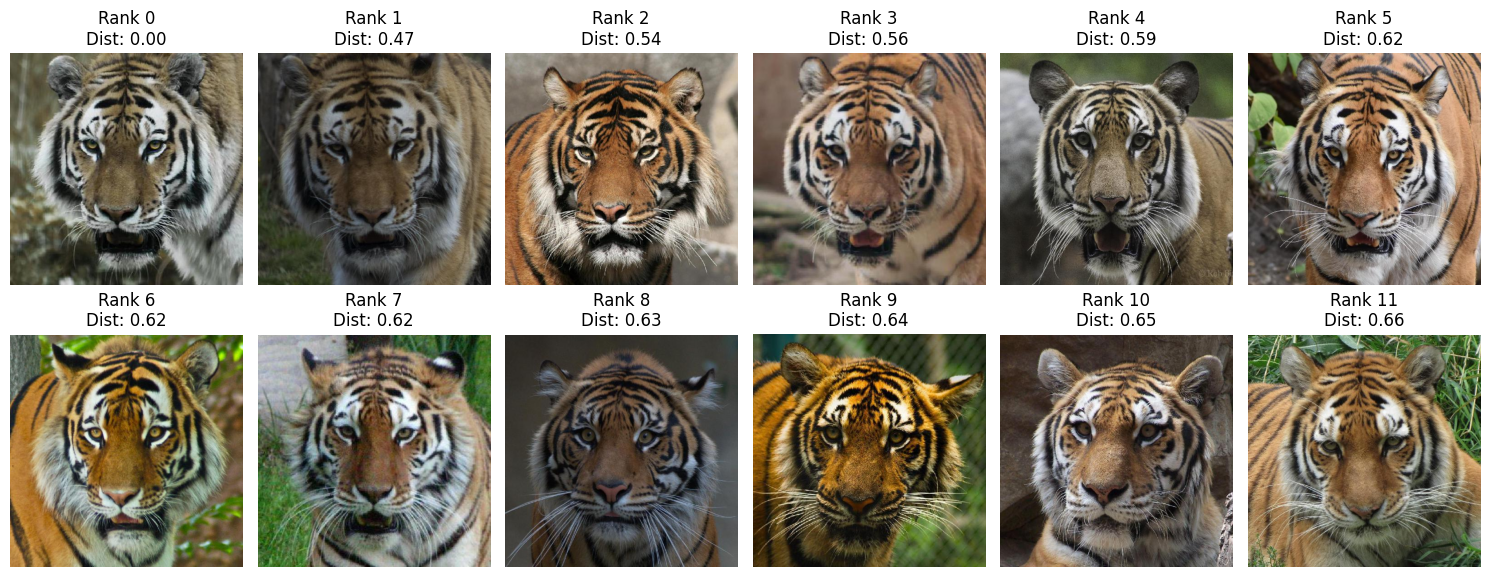

In [22]:
model.eval()
feature_list, image_path_list = [], []
extract_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for images, paths in tqdm(extract_loader, desc='특징 추출 중'):
        encoded = model.encoder(images.to(device))
        feature_list.append(encoded.cpu().numpy())
        image_path_list.extend(paths)

features = np.concatenate(feature_list, axis=0)
neighbors = NearestNeighbors(n_neighbors=12, metric='cosine')
neighbors.fit(features)

def search_and_show(query_idx):
    distances, indices = neighbors.kneighbors(features[query_idx].reshape(1, -1))
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices[0]):
        plt.subplot(2, 6, i+1)
        img = Image.open(image_path_list[idx])
        plt.imshow(img)
        plt.title(f"Rank {i}\nDist: {distances[0][i]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

search_and_show(10)